<a href="https://colab.research.google.com/github/renardelyon/Classification/blob/main/Saving_and_Loading_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Saving and Loading Models

So far we have created models and immediately used them for prediction. This is useful in a classroom setting, but most of the time you will need to deploy your model to some production system. You might also want to use one of the many pre-trained models available online in your own project.
 
In this Colab we will save and load models in both scikit-learn and TensorFlow.

## scikit-learn

### Build a Model

To begin, we will build a simple linear regression model using scikit-learn.
 
The dataset we are using is one of the datasets that comes packaged with scikit-learn, called [linnerud](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_linnerud.html#sklearn.datasets.load_linnerud). The dataset contains 20 observations of different people's ability to perform chin-ups, situps, and jumping jacks, along with measurements of their weight, waist, and resting pulse.
 
We'll create a [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model that predicts resting pulse from the other variables.

In [ ]:
from sklearn.datasets import load_linnerud
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np

bunch = load_linnerud()
df = pd.DataFrame(
  np.c_[(bunch.data, bunch.target)],
  columns=np.concatenate((bunch.feature_names, bunch.target_names))
)

model = LinearRegression()
model.fit(df[["Chins", "Situps", "Jumps"]], df["Pulse"])

### Save the Model

Now that we have built a model, let's save it. Saving a model is also known as "persisting" a model. You can learn more about persisting models [on scikit-learn's documentation](https://scikit-learn.org/stable/modules/model_persistence.html).

The scikit-learn library doesn't have any built-in ability to save models, so it delegates that work to other tools, such as Python's core [pickle](https://docs.python.org/3/library/pickle.html) module.

In [ ]:
import pickle

model_file = 'my_regression.pkl'

with open(model_file, 'wb') as output:
  pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

After running the code block above, you should be able to click on the file browsing tab in Colab and see a new file called `my_regression.pkl`. This file contains your saved model.

### Load the Model

We will now load our saved model, which we can then use to predict on new data (as seen in the cell below) or train it with additional data. To do this we rely on the pickle module again.

In [ ]:
with open(model_file, 'rb') as input:
  model_restored = pickle.load(input)

model_restored.predict([[45, 34, 2]])

## TensorFlow

### Building and Saving Your Own Model

It is possible to build and save your own model using TensorFlow 2. To demonstrate, let's create a simple model using the [linnerud](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_linnerud.html#sklearn.datasets.load_linnerud) that we used in our earlier example.

Note that we aren't following best practices for model building here. We don't split the data, we completely skip EDA, etc. This model is just being built so we can save and reload it.

In [ ]:
from sklearn.datasets import load_linnerud

import tensorflow as tf
import pandas as pd
import numpy as np

bunch = load_linnerud()

df = pd.DataFrame(
  np.c_[(bunch.data, bunch.target)],
  columns=np.concatenate((bunch.feature_names, bunch.target_names))
)

features = df.columns.values[:-1]
target = df.columns.values[-1]

df[features] = ((df[features] - df[features].min()) / 
                (df[features].max() - df[features].min()))

model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, input_shape=[len(features)], 
                        activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(8, activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu),
])

model.compile(
  optimizer='Adam',
  loss='mse',
  metrics=['mse'],
)

model.fit(df[features], df[target], epochs=100)

Saving the model is as easy as calling [`save_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model).

In [ ]:
tf.keras.models.save_model(
  model, 'linnerud'
)

We can then view the model file. The file is in TensorFlow format, but it can be saved as H5, which is another popular model storage format.



In [ ]:
! ls

Now we can reload the model.

In [ ]:
loaded_model = tf.keras.models.load_model(
  'linnerud'
)

And then use it to make predictions.

In [ ]:
loaded_model.predict(df.loc[0:2, features])

Or even train some more.

In [ ]:
loaded_model.fit(df[features], df[target], epochs=100)

### Using a Pre-Trained Model

Building and training a model from scratch can be a long and painful process. Luckily there are many publicly available models that are pre-trained and hosted online for you to freely use.
 
But why would you want to use a pre-trained model?

There may already be a model that performs some task you need to perform, such as image recognition. Or you may want to build on an existing model, utilizing [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to adapt the model to your problem.
 
Where can you find these models?

One of the most common places is the [official list](https://github.com/tensorflow/models) of pre-trained models curated by TensorFlow developers. This is often referred to as the *TensorFlow Model Garden*.
 
In this course we will be utilizing models stored in the TensorFlow detection model zoo. The zoo has models built with [TensorFlow 1](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) and [TensorFlow 2](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). We'll be focusing on the [Common Objects in Context (COCO)](http://cocodataset.org/) dataset. This dataset contains over 270,000 labeled images in 91 categories.

#### Obtain the Model File

In order to use a pre-trained model, we first need to obtain the model file. For this Colab we'll visit the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) and download the `ssd_mobilenet_v1_coco` model.

The direct link to the model changes as the model is updated, so you'll need to browse the links in the zoo and find the model. Once you click the download link, you'll have a file on your system named similarly to (but not necessarily exactly the same as):

 > `ssd_mobilenet_v1_coco_2018_01_28.tar.gz`

This is a compressed version of the model file. It is a gzipped (`.gz`) tape archive (`.tar`) file. If you want to explore the file on your local system, you might need to install a program such as [7-zip](https://www.7-zip.org/). On Mac and Linux systems you should be able to right-click on the file and extract the contents without any extra software. If you are comfortable with the command line, you can use the following command to extract the file contents.

  > `tar -xzvf ssd_mobilenet_v1_coco_2018_01_28.tar.gz`

And finally, if you just want to directly load the file to this Colab, update the file name in the code snippet below and run the code.

Also notice that the documentation for the model we are downloading says the model was built using TensorFlow version 1.

In [1]:
import urllib.request
import os

base_url = 'http://download.tensorflow.org/models/object_detection/'
file_name = 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz'

url = base_url + file_name

urllib.request.urlretrieve(url, file_name)

os.listdir()

['.config', 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz', 'sample_data']

#### Extract the Model Data

In order to load the model, it must be extracted from the compressed archive file (also called a "tarball" in this case). We will use Python's `tarfile` module to extract the contents of the file. The contents of the file will be saved in a directory named after the file. For example, the contents of `ssd_mobilenet_v1_coco_2018_01_28.tar.gz` will be saved in the `ssd_mobilenet_v1_coco_2018_01_28` directory.

In [2]:
import tarfile
import shutil

dir_name = file_name[0:-len('.tar.gz')]

if os.path.exists(dir_name):
  shutil.rmtree(dir_name) 

tarfile.open(file_name, 'r:gz').extractall('./')

os.listdir(dir_name)

['model.ckpt.data-00000-of-00001',
 'pipeline.config',
 'checkpoint',
 'model.ckpt.index',
 'frozen_inference_graph.pb',
 'saved_model',
 'model.ckpt.meta']

#### Load the Frozen Graph

There are some interesting files contained in the archive, including checkpoints that can be used for resuming model training from a specific point. We care mostly about the `frozen_inference_graph.pb` file; this file contains a trained TensorFlow graph we can use for classification.

We can load the frozen graph using TensorFlow's `GFile` method to open the file, then call `GraphDef.ParseFromString` to load the graph into memory.

In [ ]:
import tensorflow as tf

frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.io.gfile.GFile(frozen_graph, "rb") as f:
  graph_def = tf.compat.v1.GraphDef()
  loaded = graph_def.ParseFromString(f.read())

#### Explore the Graph

Now we have a graph loaded! But how do we use it? What are the inputs and outputs?
 
In a perfect world, model builders would fully document the inputs and outputs of their models, and we would know exactly how to interact with them. Unfortunately, this is not a perfect world.
 
The first step is just to determine the number of nodes in the graph.

In [ ]:
len(graph_def.node)

We have about 5,960 nodes. This is probably more than you would want to sort through manually.
 
TensorFlow automatically names nodes if you don't name them yourself. Nested nodes typically have a slash, '/', in the name.
 
How many nodes do we have without slashes?

In [ ]:
len([n for n in graph_def.node if '/' not in n.name])

That is a much more approachable number. Let's print out these "edge" nodes and see if we can see any obvious inputs and outputs.

In [ ]:
for n in graph_def.node:
  if '/' not in n.name:
    print(n.name)

At the time of creating this Colab, the edge node list was:
 
 * image_tensor
 * ToFloat
 * Shape_6
 * strided_slice_6
 * strided_slice_7
 * concat
 * Squeeze
 * concat_1
 * detection_boxes
 * detection_scores
 * num_detections
 * add
 * detection_classes
 
Many of these look computer-generated, or like it wouldn't really matter if you knew their value or not. The notable nodes seem to be:
 
 * image_tensor
 * detection_boxes
 * detection_scores
 * num_detections
 * detection_classes
 
*image_tensor* looks a lot like an input, and the *detection* classes look like output from a classification.

Let's take a look at the details of the *image_tensor*.

In [ ]:
for n in graph_def.node:
  if n.name == 'image_tensor':
    print(n)

*Placeholder* seems significant; thinking back to our "Introduction to TensorFlow" lesson, we remember that placeholders are the entrypoint for input data into the graph.
 
Let's see how many placeholders we have in this graph.

In [ ]:
for n in graph_def.node:
  if n.op == 'Placeholder':
    print(n.name)

We have only one: *image_tensor*.

What size input does the input tensor take?

Look back a few cells, and you'll see that it expects input of shape (-1, -1, -1, 3). The -1 values just indicate that the tensor accepts variable sized input, but the 3 is telling. RGB values are three values containing colors of an image. This tensor likely wants a variable number of images -- with a variable width and height -- but with three color values.

Now let's look at our *detection* nodes.

In [ ]:
for n in graph_def.node:
  if 'detection' in n.name and '/' not in n.name:
    print(n)

We can see that each node receives a float value, but we're not sure what shape the data will have.
 
However, we know the data that we need to input into the graph and the data that we can extract from the graph. We can run the graph and manually explore the outputs to determine what data and shape they conform to.

#### Run the Graph

Now that we have a graph loaded, we need to test it out. Let's download an [image of a car](https://pixabay.com/illustrations/car-sports-car-racing-car-speed-49278/) and upload that image to Colab. Rename the file `car.jpg` or change the name of the `image_filename` variable below to match the name of the file you uploaded.

In [ ]:
image_filename = 'car.jpg'

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('car.jpg')

plt.imshow(image)
plt.show()

Remember that TensorFlow allows you to request execution to any node in the graph. We want to know all of the *detection* outputs that we discovered in the graph. These were:

  * num_detections
  * detection_scores
  * detection_boxes
  * detection_classes

We will build a list of *outputs* that we want TensorFlow to generate.

In [ ]:
outputs = (
  'num_detections:0',
  'detection_classes:0',
  'detection_scores:0',
  'detection_boxes:0',
)

We also need to input our data into the graph. Our expected input shape is (-1, -1, -1, 3). Let's see the shape of our input image.

In [ ]:
image.shape

(360, 640, 3) is a 3-dimensional shape, while our model is expecting a 4-dimensional input. This is because the model can accept multiple images to train on, and we have only one image. All we need to do is wrap the image in a list.

In [ ]:
input_images = [image]

We can now execute the graph requesting our outputs and providing inputs.

In order to do this, we must first wrap the graph. This is necessary due to compatibility issues between TensorFlow version 1 and 2.

In [ ]:
def wrap_graph(graph_def, inputs, outputs, print_graph=False):
  wrapped = tf.compat.v1.wrap_function(
    lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])

  return wrapped.prune(
    tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
    tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))
    
model = wrap_graph(graph_def=graph_def,
                   inputs=["image_tensor:0"],
                   outputs=outputs)

We can now look at the input placeholder.

In [ ]:
model.inputs

And the outputs.

In [ ]:
model.outputs

And then to make predictions, we convert our image into a tensor and pass it to the model.

In [ ]:
tensor = tf.convert_to_tensor(input_images, dtype=tf.uint8)

detections = model(tensor)

#### Investigate Outputs

Now we can explore the outputs of that graph.

When the graph executed, it stored all outputs in a variable called `detections`. Let's first look at that variable and see what type it is.

In [ ]:
type(detections)

A tuple. How many elements?

In [ ]:
len(detections)

Four. That is suspiciously similar to the number of outputs we asked for. Remember that we requested:

  1. num_detections
  1. detection_classes
  1. detection_scores
  1. detection_boxes

Let's see if our first row looks like the number of detections that were found.

In [ ]:
detections[0]

This makes sense because we sent the classifier only one image, and it was of a car.
 
Let's move to the next list item.

In [ ]:
detections[1]

We get a list of a list where all of the values of the sub-list are 1 except for the first value.

The second output we requested was 'classes'. This is likely the index of the class of the detection.

And the next element?

In [ ]:
detections[2]

This element is the scores we expected.

Now for the final element.

In [ ]:
detections[3]

Four-element lists. These look a lot like bounding boxes.

We inspected our model and found that it accepts a list of variable-sized images and that it returns:
- the number of matches
- the class
- the confidence
- the bounding boxes for each object found in an image

#### Mapping Numbers to Labels

We now have enough information to know how to find, load, and use a pre-trained classification model. But how do we know what the discovered classes actually mean?
 
Typically in machine learning models, a class is represented as a number. We have to work outside of the model to turn that number back into a label that makes sense to a human.
 
Typically this takes a bit of searching. In the case of the model we just used, you can find the label-to-number mapping in a [textual protocol buffer file](https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_complete_label_map.pbtxt) on GitHub.
 
It is the responsibility of the model user to find the number-to-text mappings and apply those to the model output. In this case we can see that classification 3 is a car.

# Exercises

## Exercise 1: scikit-learn Pickling

In this exercise you will build an [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) using the [linnerud](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_linnerud.html#sklearn.datasets.load_linnerud) dataset and train the model to predict `Pulse`.

Create the regression model, and then pickle it into a file called `sgd_reg_linnerud.pkl`.

### **Student Solution**

In [ ]:
from sklearn.datasets import load_linnerud
from sklearn.linear_model import SGDRegressor
import pandas as pd
import numpy as np

linnerud_data = load_linnerud()


features_names = linnerud_data.feature_names
target = 'Pulse'
linnerud_df = pd.DataFrame(data = np.concatenate((linnerud_data.data,linnerud_data.target),axis=1),
                           columns = np.concatenate((linnerud_data.feature_names,linnerud_data.target_names)))

sgd_reg = SGDRegressor()
sgd_reg.fit(linnerud_df[features_names],linnerud_df[target])




In [ ]:
import pickle

model_file = 'sgd_reg_linnerud.pkl'

with open(model_file, 'wb') as output:
  pickle.dump(sgd_reg, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(model_file, 'rb') as input:
  model_restored = pickle.load(input)

model_restored.predict([[45, 34, 2]])

---

## Exercise 2: Using a Pre-Trained TensorFlow Model

In this exercise you'll load the COCO dataset used above into a graph. Then using [this photo from Pixabay](https://pixabay.com/photos/pets-cute-cat-dog-cute-wallpaper-3715733/), download the photo and draw a green box around every dog and a blue box around every cat.

Save the modified image as 'pets.jpg'.

### **Student Solution**

In [3]:
import tensorflow as tf

frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.io.gfile.GFile(frozen_graph, "rb") as f:
  graph_def = tf.compat.v1.GraphDef()
  loaded = graph_def.ParseFromString(f.read())

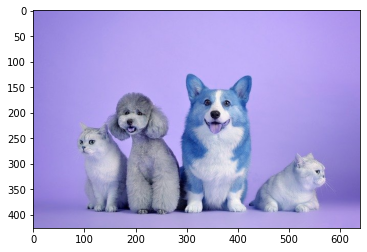

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('pets.jpg')

plt.imshow(image)
plt.show()

In [8]:
import numpy as np
input_image = np.array([image])

In [9]:
def wrap_graph(graph_def, inputs, outputs, print_graph=False):
  wrapped = tf.compat.v1.wrap_function(
    lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])

  return wrapped.prune(
    tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
    tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))

outputs = (
  'num_detections:0',
  'detection_classes:0',
  'detection_scores:0',
  'detection_boxes:0',
)
    
model = wrap_graph(graph_def=graph_def,
                   inputs=["image_tensor:0"],
                   outputs=outputs)

In [10]:
tensor = tf.convert_to_tensor(input_image, dtype=tf.uint8)

detections = model(tensor)

In [102]:
detections_box = detections[3].numpy().squeeze()
detections_class = detections[1].numpy().squeeze()

box = detections_box[detections_class != (0 or 1)] 
dt_class = detections_class[detections_class != (0 or 1)].astype('int64')

#multiply box in x coordinates by 426 and y coord with 640
box[:,(0,2)] *= 426
box[:,(1,3)] *= 640

print(dt_class)
print(box)

[88 88 18 18 17]
[[164.42307 133.1713  403.7086  293.4176 ]
 [184.07074  92.64784 397.97528 250.27673]
 [122.08189 283.54785 389.30774 436.2178 ]
 [275.82666 418.42065 395.89474 577.2443 ]
 [275.82666 418.42065 395.89474 577.2443 ]]


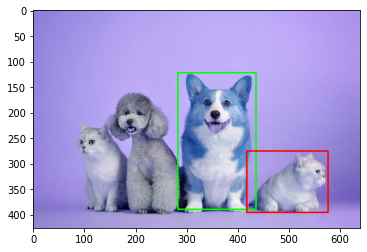

In [108]:
image_copy = np.copy(image)

for i in range(len(box)):
  if dt_class[i]== 17: #cat 
    cv.rectangle(image_copy,(box[i,1],box[i,0]),
                 (box[i,3],box[i,2]),
                 [255,0,0],2)
  elif dt_class[i]== 18: #dog
     cv.rectangle(image_copy,(box[i,1],box[i,0]),
                 (box[i,3],box[i,2]),
                 [0,255,0],2)

_ = plt.imshow(image_copy)

In [109]:
cv.imwrite('pets.jpg',image_copy)

True

---